In [1]:
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import os
import sys

import matplotlib.ticker as ticker
import scipy
from scipy import signal
from scipy.ndimage import gaussian_filter

from scipy.interpolate import RegularGridInterpolator
from scipy import interpolate

import json

In [2]:
nchan = 51                                          # Number of channels on probe in simulation
channels = np.arange(nchan)                         # list of channels

trial_dur = 1000                                    # Duration one trial (ms)
ntrials = 10                                        # Number of trials
nstim_types = 2                                     # Number of different stimuli - ON (White) and OFF (Black) flash
stimtype_list = [0, 1]                              # 0 = white, 1 = black

tstim_onset = 500                                   # Time of stimulus onset in each trial (ms)
tstim_dur = 250                                     # Duration stimulus in each trial (ms)
ncell_types = 21                                    # Number of different cell types
nlayers = 5
nmice = 58
npops = 9

stim_name_plot = ['White Flash', 'Black Flash']     # To use for titles of figures
stim_name_filename = ['white_flash', 'black_flash'] # To use for saving figures

layer_names = ['e23', 'e4', 'e5', 'e6', 'i1', 'i23', 'i4', 'i5', 'i6'] # labels for layer populations

In [3]:
plt.rcParams.update({'font.size': 16})

In [4]:
sim_data_dir = '/Users/atleeskelandrimehaug/Dropbox (Simula)/scripts_for_bmtk/data_files/sim'
exp_data_dir = '/Users/atleeskelandrimehaug/Dropbox (Simula)/scripts_for_bmtk/data_files/exp'

#### Load simulation CSD

In [5]:
#loadpaths_sim_csd = sorted(glob(os.path.join(sim_data_dir,'week3_2020/mod_21_jan_20/csd_trial_avg_noTempSmooth_*.npy')))
#loadpaths_sim_csd.append(os.path.join(sim_data_dir,'week3_2020/mod_21_jan_20/csd_trial_avg_gaussianSmooth_noTemp_2spat.npy'))
filename = 'mod_21_jan_20/csd_trial_avg_noTempSmooth_15spatSmooth_800umDiam.npy'
loadpaths_sim_csd = os.path.join(sim_data_dir,filename)

csd_sim = np.zeros((len(loadpaths_sim_csd), nstim_types, trial_dur, nchan))

csd_sim = np.load(loadpaths_sim_csd)
    

#### Load simulation LFP

In [6]:
filename = 'mod_21_jan_20/lfp_trial_avg.npy'

In [7]:
loadpath = os.path.join(sim_data_dir, filename)
lfp = np.load(loadpath)

In [8]:
for istim in range(nstim_types):
    for ch in range(nchan):
        lfp[istim,:,ch] -= np.mean(lfp[istim,:tstim_onset,ch], axis = 0)

### Load experimental LFP and CSD

In [9]:
flash_type = 'white'
#flash_type = 'black'

session_id = '715093703'
if flash_type == 'white':
    stim_type = 0
    loadpaths_csd = sorted(glob(os.path.join(exp_data_dir, session_id+'_csd.npy')))
    loadpaths_lfp = sorted(glob(os.path.join(exp_data_dir, session_id+'_lfp.npy')))
elif flash_type == 'black':
    stim_type = 1
    loadpaths_csd = sorted(glob(os.path.join(exp_csd_data_dir, 'flash_black', session_id+'_csd.npy')))
    loadpaths_lfp = sorted(glob(os.path.join(exp_lfp_data_dir, 'flash_black', session_id+'_lfp.npy')))

### Plot to check

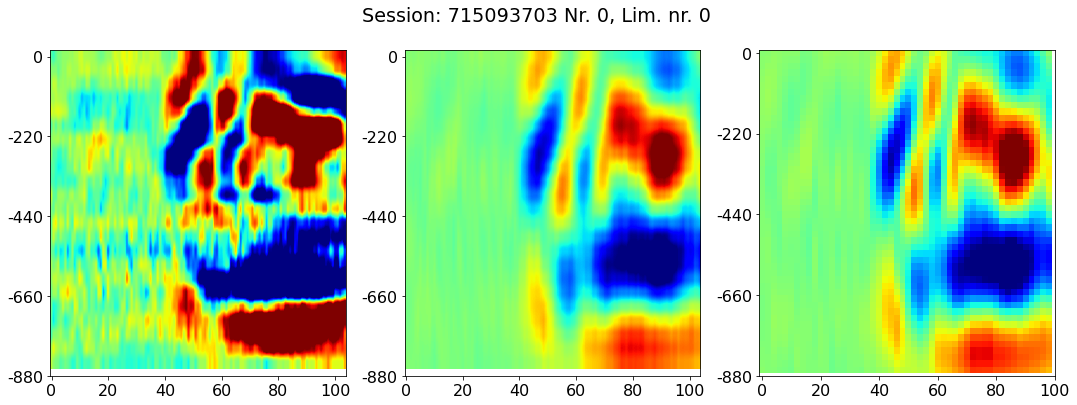

In [10]:
session_names = list()
session_data = list()
session_csd_trial_avg_raw = list()
session_csd_trial_avg_smooth = list()
session_channels_vert_pos = list()

session_names_limited = list()
session_csd_trial_avg_smooth_limited = list()
session_channels_vert_pos_limited = list()
session_wasser_limited = list()

count_lim_sessions = 0
for i, file_path in enumerate(loadpaths_csd):
    name = os.path.basename(file_path).split('_')[0]
    #print('Session: ', name)
    data = np.load(file_path, allow_pickle = True)
    
    #print('Keys: ', data[()]['cortex'].keys())
    
    session_names.append(name)
    
    session_data.append(data)
    
    t = np.array(data[()]['cortex']['csd_mean']['time_from_presentation_onset'])
    t_min = 0.0; t_max = 0.1
    mask = np.logical_and(t>=t_min, t<=t_max)
    t = t[mask]
    
    csd_trial_avg = data[()]['cortex']['csd_mean']
    csd_trial_avg = np.flip(csd_trial_avg[:,mask], axis = 0)
    
    
    session_csd_trial_avg_raw.append(csd_trial_avg)
    
    channels_vert_pos = data[()]['cortex']['channel_vertical_pos']
    
    channels_vert_pos = channels_vert_pos[::-1]
    
    channels_vert_pos -= channels_vert_pos.max()
    
    session_channels_vert_pos.append(channels_vert_pos)

    #sigma = (2,0)
    #sigma = (3,0)

    #csd_trial_avg_smooth = gaussian_filter(csd_trial_avg, sigma = sigma)
    
    csd_trial_avg_smooth = np.zeros_like(csd_trial_avg)
    
    win = signal.hann(13)
    
    for t in range(csd_trial_avg_smooth.shape[1]):
        csd_trial_avg_smooth[:,t] = signal.convolve(csd_trial_avg[:,t], win, mode='same') / sum(win)

    session_csd_trial_avg_smooth.append(csd_trial_avg_smooth)
    
    if channels_vert_pos.min() <= -780 and channels_vert_pos.min() >= -1000:
        
        session_names_limited.append(name)
        session_channels_vert_pos_limited.append(channels_vert_pos)
        session_csd_trial_avg_smooth_limited.append(csd_trial_avg_smooth)
        
        x_pos = np.linspace(-1000, 0, csd_trial_avg_smooth.shape[0], endpoint=True)

        z = csd_trial_avg_smooth
        x = np.linspace(0., 1., csd_trial_avg_smooth.shape[1], endpoint=True)
        y = np.linspace(0., 1., csd_trial_avg_smooth.shape[0], endpoint=True)
        xx, yy = np.meshgrid(x, y)
        f = interpolate.interp2d(x, y, z, kind='cubic')
        x_new = np.linspace(0., 1., 50, endpoint=True)
        y_new = np.linspace(0., 1., 50, endpoint=True)
        z_new = f(x_new, y_new)
        z_new = z_new - np.mean(z_new)

        mask = z_new>0
        z_source = np.zeros_like(z_new)
        z_source[mask] = z_new[mask]
        #z_source /= np.abs(z_source.sum())

        mask = z_new<=0
        z_sink = np.zeros_like(z_new)
        z_sink[mask] = z_new[mask]
        #z_sink /= np.abs(z_sink.sum())

        z_wasser = z_sink + z_source
        
        session_wasser_limited.append(z_wasser)

        fig, ax = plt.subplots(ncols = 3, figsize = (18,6))

        cmap_range = 50

        ax[0].imshow(csd_trial_avg*1E3, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')
        ax[1].imshow(csd_trial_avg_smooth*1E3, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')
        ax[2].imshow(z_wasser*1E3, cmap = 'jet', vmin = -cmap_range, vmax = cmap_range, aspect = 'auto')

        ax[0].set_yticks(np.linspace(0, csd_trial_avg.shape[0], 5, endpoint = True))
        ax[0].set_yticklabels(np.linspace(channels_vert_pos.max(), channels_vert_pos.min(), 5, endpoint = True, dtype = int))

        ax[1].set_yticks(np.linspace(0, csd_trial_avg.shape[0], 5, endpoint = True))
        ax[1].set_yticklabels(np.linspace(channels_vert_pos.max(), channels_vert_pos.min(), 5, endpoint = True, dtype = int))

        ax[2].set_yticks(np.linspace(0, 50, 5, endpoint = True))
        ax[2].set_yticklabels(np.linspace(channels_vert_pos.max(), channels_vert_pos.min(), 5, endpoint = True, dtype = int))

        ax[0].set_xticks(np.linspace(0,120,6,endpoint = True))
        ax[0].set_xticklabels(np.linspace(0,100,6,endpoint = True, dtype = int))
        
        ax[1].set_xticks(np.linspace(0,120,6,endpoint = True))
        ax[1].set_xticklabels(np.linspace(0,100,6,endpoint = True, dtype = int))
        
        ax[2].set_xticks(np.linspace(0,50,6,endpoint = True))
        ax[2].set_xticklabels(np.linspace(0,100,6,endpoint = True, dtype = int))
        
        #ax[0].set_title(name); ax[1].set_title(name); ax[2].set_title('Session: '+name + ' Nr. '+ str(i))
        #idx = np.where(cluster_names == name)[0]
        
        fig.suptitle('Session: '+name + ' Nr. '+ str(i)+', Lim. nr. '+str(count_lim_sessions))#+', Cluster: '+str(cluster_number[idx][0][0]))

        
        count_lim_sessions += 1

Session:  715093703


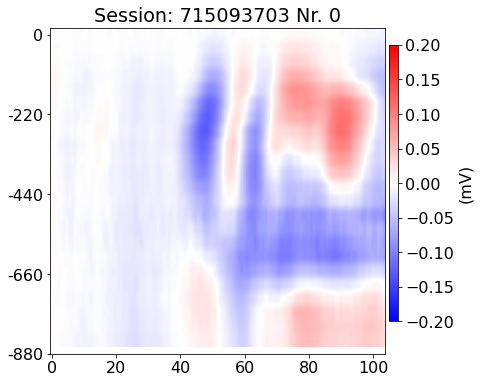

In [11]:

sessions_lfp_limited = list()


for i, file_path in enumerate(loadpaths_lfp):
    name = os.path.basename(file_path).split('_')[0]
    print('Session: ', name)
    data = np.load(file_path, allow_pickle = True)
    
    #print('Keys: ', data[()]['cortex'].keys())
    
    t = np.array(data[()]['cortex']['lfp_mean']['time_from_presentation_onset'])
    t_min = 0.0; t_max = 0.1
    mask = np.logical_and(t>=t_min, t<=t_max)
    t = t[mask]
    
    lfp_trial_avg = data[()]['cortex']['lfp_mean']
    lfp_trial_avg = np.flip(lfp_trial_avg[:,mask], axis = 0)
    
    channels_vert_pos = data[()]['cortex']['channel_vertical_pos']
    
    channels_vert_pos = channels_vert_pos[::-1]
    
    channels_vert_pos -= channels_vert_pos.max()
    
    if channels_vert_pos.min() < -800 and channels_vert_pos.min() > -1000:
        
        sessions_lfp_limited.append(lfp_trial_avg)

        fig, ax = plt.subplots(ncols = 1, figsize = (6,6))

        cmap_range = 0.20

        im = ax.imshow(lfp_trial_avg*1E3, cmap = 'bwr', aspect = 'auto', vmin = -cmap_range, vmax = cmap_range)
        
        ax.set_yticks(np.linspace(0, lfp_trial_avg.shape[0], 5, endpoint = True))
        ax.set_yticklabels(np.linspace(channels_vert_pos.max(), channels_vert_pos.min(), 5, endpoint = True, dtype = int))
        
        ax.set_title('Session: '+name + ' Nr. '+ str(i))
        
        cbaxes = fig.add_axes([0.91, 0.20, 0.02, 0.64])
        cb = fig.colorbar(im, ax = ax, cax = cbaxes); 
        cb.set_label('(mV)', fontsize = '16')
        
        ax.set_xticks(np.linspace(0,120,6,endpoint=True,dtype=int))
        ax.set_xticklabels(np.linspace(0,100,6,endpoint=True,dtype=int))
        


### Load simulation firing rates

In [12]:
#filename = '..cell_count_layers.txt'
filename = 'cell_count_layers_onlyPVasInhib.txt'

fullpath = os.path.join(sim_data_dir, filename)
with open(fullpath, 'r') as filehandle:
    filecontent = json.load(filehandle)
    layer_names_temp = list(filecontent.keys())
    
    num_neurons_layers = np.zeros((len(layer_names)))
    
    i = 0
    while (i < len(layer_names)):
        num_neurons_layers[i] = filecontent[layer_names_temp[i]]
        print(layer_names_temp[i])
        #print(num_neurons_layers[i])
        i += 1

23e
4e
5e
6e
1i
23i
4i
5i
6i


In [13]:
filename = 'mod_21_jan_20/firing_rate_layerpops_onlyPVasInhib.txt'

In [14]:
fir_rate_layerpops_sim = np.zeros((len(layer_names),nstim_types,trial_dur))


fir_rate_layerpops = {}
loadpath = os.path.join(sim_data_dir, filename)

with open(loadpath, 'r') as filehandle:
    filecontent = json.load(filehandle)
    layer_names_temp = list(filecontent.keys())

    for ipop, pop_key in enumerate(layer_names_temp):
        #print(pop_key)
        fir_rate_layerpops[pop_key] = np.asarray(filecontent[pop_key])
        fir_rate_layerpops_sim[ipop] = np.asarray((filecontent[pop_key]/num_neurons_layers[None,ipop,None,None])*1E3)
        

#### Load experimental firing rates

In [15]:
filename = 'individ_cells_firing_rate_layers.npy'
loadpath_exp_fir_rates = os.path.join(exp_data_dir, filename)
fir_rate_layerpops_exp = np.load(loadpath_exp_fir_rates, allow_pickle = True)

#### Compute averages and standard deviations

In [16]:
time_bin_start = -0.1 # seconds before stimulus onset
time_bin_end = 0.5    # seconds after stimulus onset
nbins_pr_second = 1000 # 1 ms bins
nbins = int((time_bin_end-time_bin_start)*nbins_pr_second+1)
time_bin_edges = np.linspace(time_bin_start, time_bin_end, nbins)

ratio_bins_second = (time_bin_end-time_bin_start)/nbins
print(ratio_bins_second)

0.0009983361064891847


In [17]:
start_twoi = 0 # start time window of interest (ms)
end_twoi = 100 # end time window of interest (ms)

# Index time window of interest for simulations
idx_start_twoi_sim = start_twoi+500 
idx_end_twoi_sim = end_twoi+500
len_idx_twoi_sim = idx_end_twoi_sim-idx_start_twoi_sim

# Index time window of interest for experimental data
idx_start_twoi_exp = int(start_twoi/(ratio_bins_second*1E3) - time_bin_edges[0]/ratio_bins_second)
idx_end_twoi_exp = int(end_twoi/(ratio_bins_second*1E3) - time_bin_edges[0]/ratio_bins_second)
len_idx_twoi_exp = idx_end_twoi_exp - idx_start_twoi_exp

In [18]:
avg_fir_rate_layerpops_sim = np.zeros((nstim_types,len(layer_names),trial_dur))
std_fir_rate_layerpops_sim = np.zeros_like(avg_fir_rate_layerpops_sim)

avg_fir_rate_layerpops_exp = np.zeros((nstim_types,len(layer_names),nbins-1))
std_fir_rate_layerpops_exp = np.zeros_like(avg_fir_rate_layerpops_exp)

for istim in range(nstim_types):
    for ipop in range(len(layer_names)):
        if layer_names[ipop] != 'i1':
            print(layer_names[ipop])
            avg_fir_rate_layerpops_sim[istim,ipop] = np.mean(fir_rate_layerpops_sim[ipop][istim],axis = 0)
            std_fir_rate_layerpops_sim[istim,ipop] = np.std(fir_rate_layerpops_sim[ipop][istim],axis = 0)
            
            avg_fir_rate_layerpops_exp[istim,ipop] = np.mean(fir_rate_layerpops_exp[istim][ipop], axis = 0)
            std_fir_rate_layerpops_exp[istim,ipop] = np.std(fir_rate_layerpops_exp[istim][ipop], axis = 0)

e23
e4
e5
e6
i23
i4
i5
i6
e23
e4
e5
e6
i23
i4
i5
i6


In [19]:
layer_names_plot = ['E2/3', 'E4', 'E5', 'E6', 'I1', 'I2/3', 'I4', 'I5', 'I6']

In [20]:
avg_fir_rate_layerpops_sim *= 1E3

In [21]:
layer_borders_2 = [-0, -100, -310, -430, -650, -850]

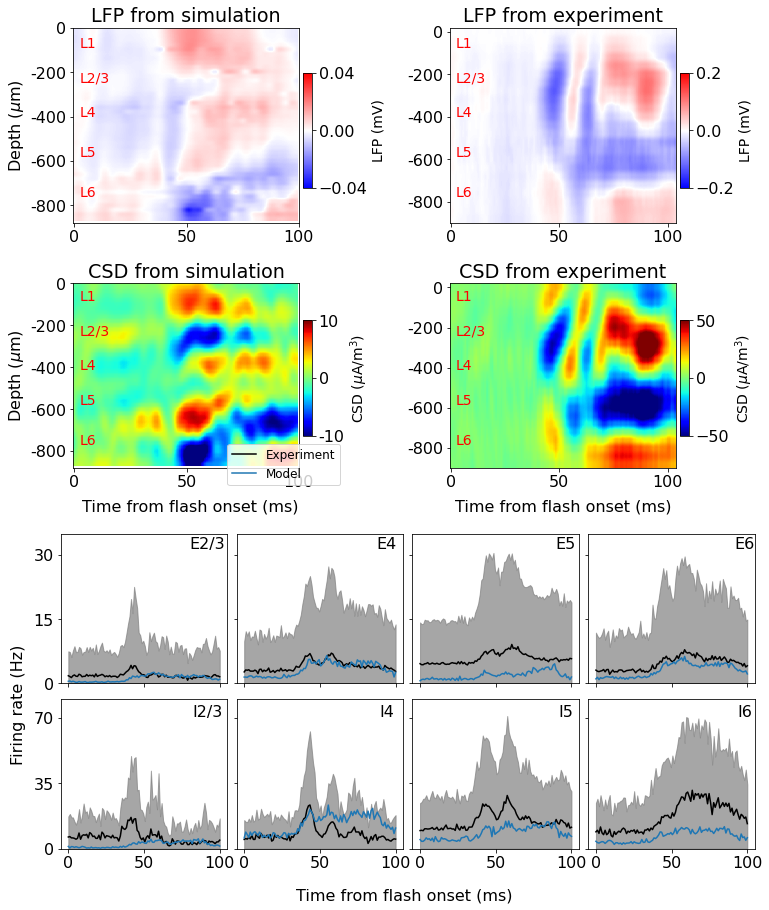

In [22]:
grid = plt.GridSpec(800, 800, hspace=1.2, wspace=0.8)
fig = plt.figure(figsize=(18, 16))

ncols = 4
axlabels_fontsize = 18

istim = 0

for j in range(ncols):
    ax_fRate_e = fig.add_subplot(grid[500:638,(50+140*j):int(50+140*(j+.95))])
    ax_fRate_i = fig.add_subplot(grid[652:790,(50+140*j):int(50+140*(j+.95))])
    
    ax_fRate_e.set_ylim([0,35])
    ax_fRate_i.set_ylim([0,80])
    
    ax_fRate_e.set_yticks(np.linspace(0, 30, 3, endpoint = True))
    ax_fRate_e.set_yticklabels(np.linspace(0, 30, 3, endpoint = True, dtype = int))
    
    ax_fRate_i.set_yticks(np.linspace(0, 70, 3, endpoint = True))
    ax_fRate_i.set_yticklabels(np.linspace(0, 70, 3, endpoint = True, dtype = int))

    if j == 0:
        #ax_fRate_e.set_ylabel('Firing rate (Hz)', fontsize = axlabels_fontsize)
        plt.figtext(x = 0.135, y = 0.21, s = 'Firing rate (Hz)', rotation = 'vertical')
        plt.figtext(x = 0.355, y = 0.09, s = 'Time from flash onset (ms)', rotation = 'horizontal')
        
        # Experimental firing rate
        ax_fRate_e.plot(np.linspace(start_twoi,end_twoi,end_twoi-start_twoi), avg_fir_rate_layerpops_exp[istim,j,idx_start_twoi_exp:idx_end_twoi_exp], color = 'k', label = 'Experiment')
        ax_fRate_e.fill_between(np.linspace(start_twoi,end_twoi,len_idx_twoi_exp), \
                avg_fir_rate_layerpops_exp[stim_type, j, idx_start_twoi_exp:idx_end_twoi_exp]+
                std_fir_rate_layerpops_exp[stim_type, j, idx_start_twoi_exp:idx_end_twoi_exp], color = (.5,.5,.5), alpha = 0.7)
        
        ax_fRate_i.plot(np.linspace(start_twoi,end_twoi,end_twoi-start_twoi),avg_fir_rate_layerpops_exp[istim,j+5,idx_start_twoi_exp:idx_end_twoi_exp], color = 'k')
        ax_fRate_i.fill_between(np.linspace(start_twoi,end_twoi,len_idx_twoi_exp), \
                avg_fir_rate_layerpops_exp[stim_type, j+5, idx_start_twoi_exp:idx_end_twoi_exp]+
                std_fir_rate_layerpops_exp[stim_type, j+5, idx_start_twoi_exp:idx_end_twoi_exp], color = (.5,.5,.5), alpha = 0.7)
        
        ax_fRate_e.plot(np.linspace(start_twoi,end_twoi,end_twoi-start_twoi), fir_rate_layerpops_sim[j,istim,idx_start_twoi_sim:idx_end_twoi_sim], label = 'Model')        
        ax_fRate_i.plot(np.linspace(start_twoi,end_twoi,end_twoi-start_twoi), fir_rate_layerpops_sim[j+5,istim,idx_start_twoi_sim:idx_end_twoi_sim])        

        
    else:
        ax_fRate_e.set_yticklabels([])
        ax_fRate_i.set_yticklabels([])
             
        # Experimental firing rate
        ax_fRate_e.plot(np.linspace(start_twoi,end_twoi,end_twoi-start_twoi),avg_fir_rate_layerpops_exp[istim,j,idx_start_twoi_exp:idx_end_twoi_exp], color = 'k')
        ax_fRate_e.fill_between(np.linspace(start_twoi,end_twoi,len_idx_twoi_exp), \
                avg_fir_rate_layerpops_exp[stim_type, j, idx_start_twoi_exp:idx_end_twoi_exp]+
                std_fir_rate_layerpops_exp[stim_type, j, idx_start_twoi_exp:idx_end_twoi_exp], color = (.5,.5,.5), alpha = 0.7)
        
        ax_fRate_i.plot(np.linspace(start_twoi,end_twoi,end_twoi-start_twoi),avg_fir_rate_layerpops_exp[istim,j+5,idx_start_twoi_exp:idx_end_twoi_exp], color = 'k')
        ax_fRate_i.fill_between(np.linspace(start_twoi,end_twoi,len_idx_twoi_exp), \
                avg_fir_rate_layerpops_exp[stim_type, j+5, idx_start_twoi_exp:idx_end_twoi_exp]+
                std_fir_rate_layerpops_exp[stim_type, j+5, idx_start_twoi_exp:idx_end_twoi_exp], color = (.5,.5,.5), alpha = 0.7)

        ax_fRate_e.plot(np.linspace(start_twoi,end_twoi,end_twoi-start_twoi), fir_rate_layerpops_sim[j,istim,idx_start_twoi_sim:idx_end_twoi_sim])
        ax_fRate_i.plot(np.linspace(start_twoi,end_twoi,end_twoi-start_twoi), fir_rate_layerpops_sim[j+5,istim,idx_start_twoi_sim:idx_end_twoi_sim])        

        
    ax_fRate_e.set_xticklabels([])
    
    ax_fRate_e.text(.88+j*.0192,0.9,layer_names_plot[j],
    horizontalalignment='center',
    transform=ax_fRate_e.transAxes)

    ax_fRate_i.text(.88+j*.0192,0.88,layer_names_plot[j+5],
    horizontalalignment='center',
    transform=ax_fRate_i.transAxes)
    
session_nr = 0
    
channels_vert_pos = session_channels_vert_pos_limited[session_nr].values
channels_min_pos_plot = -800
    
ax_lfp_sim = fig.add_subplot(grid[35:215,60:240])


cmap_range_lfp_sim = 0.04




endchan_exp_for_sim = np.where(np.linspace(0,-1000,nchan)==channels_vert_pos.min())[0][0]
endchan_sim_for_800 = 40

im_lfp_sim = ax_lfp_sim.imshow(lfp[istim, 500:600, :endchan_exp_for_sim].T, cmap = 'bwr', vmin = -cmap_range_lfp_sim, vmax = cmap_range_lfp_sim, aspect = 'auto')

ax_lfp_sim.set_title('LFP from simulation')

ticks = [tick for tick in ax.get_yticks()]
plt.ylim(endchan_exp_for_sim, ticks[0])
ax_lfp_sim.set_yticklabels([0,-200,-400,-600,-800])


ax_lfp_sim.set_xticks(np.linspace(0,100,3,endpoint = True))
ax_lfp_sim.set_xticklabels(np.linspace(0,100,3,endpoint = True, dtype = int))

cbaxes = fig.add_axes([0.36, 0.708, 0.007, 0.1])
cb = plt.colorbar(im_lfp_sim, ax = ax_lfp_sim, cax = cbaxes);
cb.set_ticks(np.arange(-cmap_range_lfp_sim, cmap_range_lfp_sim+1, cmap_range_lfp_sim))
cb.set_label('LFP (mV)', fontsize = 14)
cb.ax.tick_params(labelsize=16)



cmap_range_lfp_exp = 0.20
ax_lfp_exp = fig.add_subplot(grid[35:215,360:540])
im_lfp_exp = ax_lfp_exp.imshow(sessions_lfp_limited[session_nr]*1E3,cmap = 'bwr', aspect = 'auto', vmin = -cmap_range_lfp_exp, vmax = cmap_range_lfp_exp)

ax_lfp_exp.set_title('LFP from experiment')

ax_lfp_exp.set_yticklabels([0,0,-200,-400,-600,-800])

ax_lfp_exp.set_xticks(np.linspace(0,120,3,endpoint = True))
ax_lfp_exp.set_xticklabels(np.linspace(0,100,3,endpoint = True, dtype = int))

cbaxes = fig.add_axes([0.651, 0.708, 0.007, 0.1])
cb = plt.colorbar(im_lfp_exp, ax = ax_lfp_exp, cax = cbaxes);
cb.set_ticks(np.arange(-cmap_range_lfp_exp, cmap_range_lfp_exp+1, cmap_range_lfp_exp))
cb.set_label('LFP (mV)', fontsize = 14)
cb.ax.tick_params(labelsize=16)


ax_csd_sim = fig.add_subplot(grid[270:440,60:240])

#cmap_range_sim = 13
cmap_range_sim = 10


im_csd_sim = ax_csd_sim.imshow(csd_sim[stim_type, 500:600, :endchan_exp_for_sim].T*1E6, origin = 'upper', cmap = 'jet', vmin = -cmap_range_sim, vmax = cmap_range_sim, aspect = 'auto')


ax_csd_sim.set_title('CSD from simulation')

#ax_csd_sim.set_yticks(np.linspace(0, endchan_exp_for_sim, 5, endpoint = True))
#ax_csd_sim.set_yticklabels(np.linspace(0, channels_vert_pos.min(), 5, endpoint = True, dtype = int))

ticks = [tick for tick in ax.get_yticks()]
plt.ylim(endchan_exp_for_sim, ticks[0])
ax_csd_sim.set_yticklabels([0,-200,-400,-600,-800])


ax_csd_sim.set_xticks(np.linspace(0,100,3,endpoint = True))
ax_csd_sim.set_xticklabels(np.linspace(0,100,3,endpoint = True, dtype = int))

cbaxes = fig.add_axes([0.36, 0.493, 0.007, 0.1])
cb = plt.colorbar(im_csd_sim, ax = ax_csd_sim, cax = cbaxes);
cb.set_ticks(np.arange(-cmap_range_sim, cmap_range_sim+1, cmap_range_sim))
cb.set_ticklabels(np.arange(-10, 10+1, 10))
cb.set_label('CSD ($\mu$A/m$^3$)', fontsize = 14)
cb.ax.tick_params(labelsize=16)



cmap_range_exp = 50
#cmap_range_exp_wasser = 50
ax_csd_exp = fig.add_subplot(grid[270:440,360:540])
im_csd_exp = ax_csd_exp.imshow(session_csd_trial_avg_smooth_limited[session_nr]*1E3, aspect = 'auto', cmap = 'jet', vmin = -cmap_range_exp, vmax = cmap_range_exp)    
#im_csd_exp = ax_csd_exp.imshow(session_wasser_limited[session_nr]*1E3, aspect = 'auto', cmap = 'jet', vmin = -cmap_range_exp_wasser, vmax = cmap_range_exp_wasser)    


ax_csd_exp.set_title('CSD from experiment')

#ax_csd_exp.set_yticks(np.linspace(0, csd_trial_avg.shape[0]-2, 5, endpoint = True))
#ax_csd_exp.set_yticklabels(np.linspace(channels_vert_pos.max(), channels_vert_pos.min(), 5, endpoint = True, dtype = int))

ax_csd_exp.set_yticklabels([0,0,-200,-400,-600,-800])

ax_csd_exp.set_xticks(np.linspace(0,120,3,endpoint = True))
ax_csd_exp.set_xticklabels(np.linspace(0,100,3,endpoint = True, dtype = int))


cbaxes = fig.add_axes([0.651, 0.493, 0.007, 0.1])
cb = plt.colorbar(im_csd_exp, ax = ax_csd_exp, cax = cbaxes);
cb.set_ticks(np.arange(-cmap_range_exp, cmap_range_exp+1, cmap_range_exp))
#cb.set_ticklabels(np.arange(-50,50+1,50))
cb.set_label('CSD ($\mu$A/m$^3$)', fontsize = 14)
cb.ax.tick_params(labelsize=16)

plt.figtext(x = 0.478, y = 0.427, s = 'Time from flash onset (ms)', rotation = 'horizontal')
plt.figtext(x = 0.19, y = 0.427, s = 'Time from flash onset (ms)', rotation = 'horizontal')

ax_lfp_sim.set_ylabel('Depth ($\mu$m)')
ax_csd_sim.set_ylabel('Depth ($\mu$m)')

#plt.figtext(x = 0.478, y = 0.427, s = 'Depth ($\mu$m)', rotation = 'vertical')
#plt.figtext(x = 0.17, y = 0.427, s = 'Depth ($\mu$m)', rotation = 'vertical')

font = {
        'color':  'red',
        'weight': 'normal',
        'size': 14,
}
    

plt.figtext(.188,.83, 'L1', fontdict = font)
plt.figtext(.188,.80, 'L2/3', fontdict = font)
plt.figtext(.188,.77, 'L4', fontdict = font)
plt.figtext(.188,.735, 'L5', fontdict = font)
plt.figtext(.188,.70, 'L6', fontdict = font)

vert_shift = -.22
plt.figtext(.188,.83+vert_shift, 'L1', fontdict = font)
plt.figtext(.188,.80+vert_shift, 'L2/3', fontdict = font)
plt.figtext(.188,.77+vert_shift, 'L4', fontdict = font)
plt.figtext(.188,.74+vert_shift, 'L5', fontdict = font)
plt.figtext(.188,.705+vert_shift, 'L6', fontdict = font)


hor_shift = .29
plt.figtext(.188+hor_shift,.83, 'L1', fontdict = font)
plt.figtext(.188+hor_shift,.80, 'L2/3', fontdict = font)
plt.figtext(.188+hor_shift,.77, 'L4', fontdict = font)
plt.figtext(.188+hor_shift,.735, 'L5', fontdict = font)
plt.figtext(.188+hor_shift,.70, 'L6', fontdict = font)


plt.figtext(.188+hor_shift,.83+vert_shift, 'L1', fontdict = font)
plt.figtext(.188+hor_shift,.80+vert_shift, 'L2/3', fontdict = font)
plt.figtext(.188+hor_shift,.77+vert_shift, 'L4', fontdict = font)
plt.figtext(.188+hor_shift,.74+vert_shift, 'L5', fontdict = font)
plt.figtext(.188+hor_shift,.705+vert_shift, 'L6', fontdict = font)

fig.legend(bbox_to_anchor = (0.267,0.41), prop={'size': 12}, fontsize = 22)


fig_name = 'bmtk_lfp_csd_firing_rates_new_animal_white_flash_old_filtering_w_labels.png'

fig_name = 'bmtk_lfp_csd_firing_rates_new_animal_white_flash_old_filtering_w_labels_new_csd_diams.png'


#fig.savefig(savepath, bbox_to_inches = 'tight')